# Example of using the network

This Notebook shows the usage of pretained ZePHyR network on BOP dataset. 

BOP dataset can be downloaded from [BOP Challenge](https://bop.felk.cvut.cz/datasets/). In this notebook, we assume LM-O model files together with bop test set is downloaded and stored in the structure defined in BOP Challenge. 

This script also assumes the preprocessed dataset has been downloaded. Note that only the data of model point clouds (`MODEL_DATA_TPATH`) and the txt file storing PPF pose hypotheses (`PPF_RESULT_PATH`) will be used in this script. 

In [1]:
DATASET_NAME = "lmo"
PREPROCESSED_DATA_FOLDER = "../python/zephyr/data/lmo/matches_data_test/" # The path to the preprocessed data folder
CKPT_PATH = "../python/zephyr/ckpts/final_lmo.ckpt" # The path to the checkpoint
USE_ICP = False # Not using ICP for LMO dataset, as it only uses PPF hypotheses, which are already after ICP processing. 
BOP_ROOT = "/home/qiaog/datasets/bop/" # Change this to the root folder of downloaded BOP dataset
PPF_RESULT_PATH = "../python/zephyr/data/lmo_list_bop_test_v1.txt" # A text file stroing all PPF pose hypotheses
MODEL_DATA_TPATH = "../python/zephyr/data/lmo/matches_data_test/model_data/model_cloud_{:02d}.npz" # path template to the sampled point cloud

In [2]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import cv2
import pytorch_lightning as pl

from zephyr.models import getModel
from zephyr.datasets import getDataloader
from zephyr.options import getOptions, checkArgs

from zephyr.utils.bop_dataset import BopDataset, BopDatasetArgs
from zephyr.utils.metrics import add, adi
from zephyr.utils import K2meta, to_np

%load_ext autoreload
%autoreload 2

## Initialize the BOP dataset and get one data point

In [3]:
'''Set up the arguments for the model'''
parser = getOptions()
args = parser.parse_args([])

# Model-related
args.model_name = "pn2"
args.dataset = "HSVD_diff_uv_norm"
args.no_valid_proj = True
args.no_valid_depth = True
args.inconst_ratio_th = 100
args.icp = USE_ICP

# Dataset-related
args.dataset_root = [PREPROCESSED_DATA_FOLDER]
args.dataset_name = [DATASET_NAME]
args.resume_path = CKPT_PATH
args.test_dataset = True

In [5]:
'''Initialize pytorch dataloader and model'''
# dataloader is only needed for the getPointNetData() function
loader = getDataloader(args)[0]
model = getModel(args.model_name, args, mode='test')
model = model.to(0)
model = model.eval()

Initializing lmo dataset from ../python/zephyr/data/lmo/matches_data_test/
Using BOP dataset format. Total dataset: 0
Using PointNet Dataset
Initializating test dataset ['u', 'v', 'H_diff', 'S_diff', 'V_diff', 'D_diff', 'norm_cos']
dim_agg: 0 dim_point: 7
No loss on the best hypotheses
PointNet2: extra_bottleneck_dim = 0
mask: [] xyz: [0, 1] points: [2, 3, 4, 5, 6]


In [6]:
'''Initialize the BOP dataset'''
# Set up the options
bop_args = BopDatasetArgs(
    bop_root=BOP_ROOT, 
    dataset_name="lmo", 
    model_type=None,
    split_name="bop_test", # This indicates we want to use the testing set defined in BOP challenge (different than original test set)
    split="test", 
    split_type=None, 
    ppf_results_file=PPF_RESULT_PATH, 
    skip=1, # Iterate over all test samples, with no skipping
)

bop_dataset = BopDataset(bop_args)

print("Length of the test dataset:", len(bop_dataset))

Length of the test dataset: 1445


In [9]:
'''Get one datapoint in the BOP dataset'''
data_raw = bop_dataset[150]

# Extract the data needed for test forwarding
obj_id, scene_id, im_id = data_raw['obj_id'], data_raw['scene_id'], data_raw['im_id']
img, depth, scene_camera = data_raw['img'], data_raw['depth'], data_raw['scene_camera']
scene_meta = data_raw['scene_meta']
mat_gt = data_raw['mat_gt']
cam_K = np.asarray(scene_camera['cam_K']).reshape((3, 3))

# Load the information of the model point cloud from the pre-processed dataset
model_data_path = MODEL_DATA_TPATH.format(obj_id)
model_data = np.load(model_data_path)
model_points, model_colors, model_normals = model_data['model_points'], model_data['model_colors'], model_data['model_normals']

# Load the pose hypotheses from PPF results
ppf_trans, ppf_scores = bop_dataset.getPPFHypos(obj_id, scene_id, im_id)
pose_hypos = ppf_trans

# Get the proper error function according to whether the object is symmetric or not
is_sym = obj_id in bop_dataset.sym_obj_ids
err_func = adi if is_sym else add

# Compute the ADD/ADI error for pose hypotheses r.w.t. grouth truth pose
pp_err = np.asarray([err_func(mat[:3,:3], mat[:3, 3], mat_gt[:3, :3], mat_gt[:3, 3], model_points) for mat in pose_hypos])

## Data required for network inference

Up to this point, the data needed for network inference is all in the global namespace, including:
* `img`: RGB image, np.ndarray of size (H, W, 3) in np.uint8
* `depth`: depth map, np.ndarray of size (H, W) in np.float, in meters
* `cam_K`: camera intrinsic matrix, np.ndarray of size (3, 3) in np.float
* `model_colors`: colors of model point cloud, np.ndarray of size (N, 3) in float, scaled in [0, 1]
* `model_points`: xyz coordinates of model point cloud, np.ndarray of size (N, 3) in float, in meters
* `model_normals`: normal vectors of mdoel point cloud, np.ndarray of size (N, 3) in float, each L2 normalized
* `pose_hypos`: pose hypotheses in camera frame, np.ndarray of size (K, 4, 4) in float

If you need to use the pretrained model in some other context, please prepare data in the above format and pass them into the `networkInference()` function. 

In [10]:
data = {
    "img": img, "depth": depth, "cam_K": cam_K, 
    "model_colors": model_colors, "model_points": model_points, "model_normals":model_normals, 
    "pose_hypos": pose_hypos
}

for k, v in data.items():
    print(k, type(v), v.shape, v.dtype, v.max(), v.min())

img <class 'numpy.ndarray'> (480, 640, 3) uint8 255 0
depth <class 'numpy.ndarray'> (480, 640) float32 2.432 0.0
cam_K <class 'numpy.ndarray'> (3, 3) float64 573.57043 0.0
model_colors <class 'numpy.ndarray'> (570, 3) float64 0.6624836601307194 0.12000000000000002
model_points <class 'numpy.ndarray'> (570, 3) float64 0.045578560000000004 -0.045749572999999995
model_normals <class 'numpy.ndarray'> (570, 3) float64 0.99860799 -0.99988192
pose_hypos <class 'numpy.ndarray'> (100, 4, 4) float64 1.301013641 -0.9992011491820504


In [11]:
def networkInference(model, dataloader, data):
    # Convert the data to pytorch data format
    scoring_data = {}
    img_blur = cv2.GaussianBlur(data['img'], (5,5), 0)
    scoring_data['img'] = torch.from_numpy(img_blur/255.)
    scoring_data['depth'] = torch.from_numpy(data['depth'])
    scoring_data['transforms'] = torch.from_numpy(data['pose_hypos'])
    scoring_data['meta_data'] = K2meta(data['cam_K'])
    scoring_data['model_points'] = torch.from_numpy(data['model_points'])
    scoring_data['model_colors'] = torch.from_numpy(data['model_colors'])
    scoring_data['model_normals'] = torch.from_numpy(data['model_normals'])
    
    # If we have GT error, store it. Otherwise use a dummy one
    if "pp_err" not in data:
        scoring_data['pp_err'] = torch.zeros(len(data['pose_hypos']))
    else:
        scoring_data['pp_err'] = data['pp_err']
    
    # Pre-process the data
    point_x, uv_original = dataloader.dataset.getPointNetData(scoring_data, return_uv_original = True)
    
    # Network inference
    pred_score = model({"point_x": point_x.to(model.device)})
    
    # Note that some hypotheses are excluded beforehand if it violates free-space violation too much
    # Therefore, the pp_err may be changed to a different size. 
    return pred_score, scoring_data['pp_err']

# Use the add/adi error
data['pp_err'] = pp_err

model = model.to(0)
pred_score, err = networkInference(model, loader, data)

pred_score = to_np(pred_score).reshape(-1)

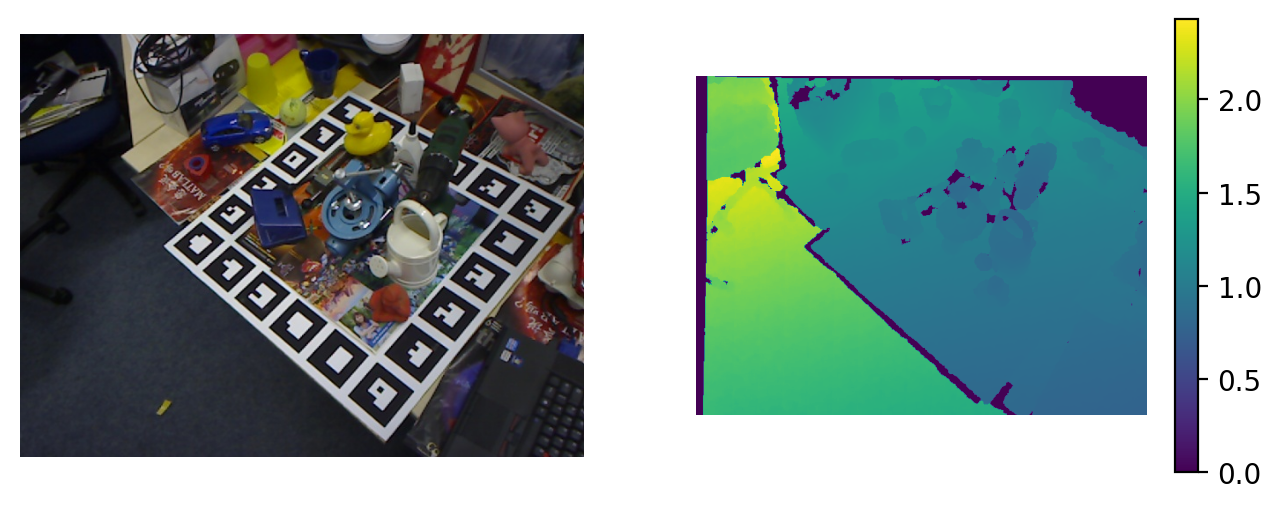

In [12]:
'''The observed image and depth map'''
plt.figure(figsize=(8, 3), dpi=200)
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(depth)
plt.axis('off')
plt.colorbar()
plt.show()

INFO - 2021-06-05 23:17:06,532 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


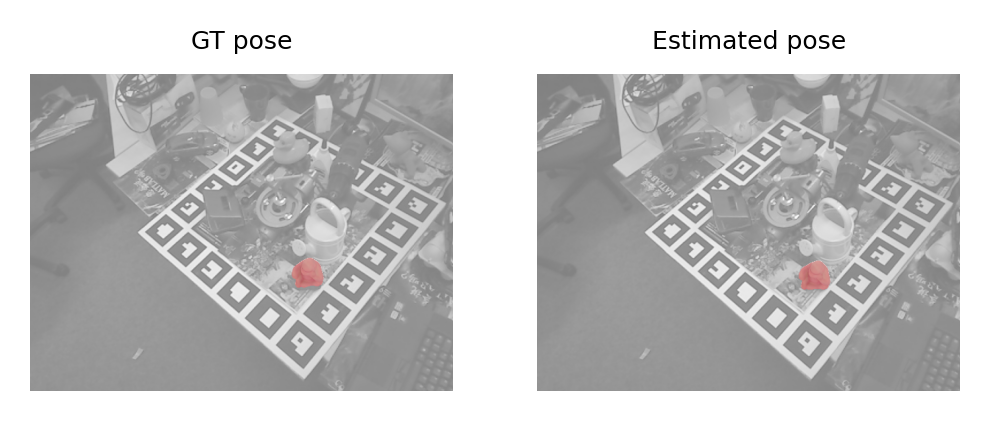

In [13]:
from zephyr.utils.renderer import Renderer, blend
from zephyr.utils.vis import plotImages

# Render the GT and predicted pose
model_path = bop_dataset.model_tpath.format(obj_id = obj_id)

# GT pose
renderer = Renderer(K2meta(cam_K))
renderer.addObject(obj_id, model_path, pose=mat_gt, mm2m=True)
gt_color, gt_depth = renderer.render()

gt_blend = blend(img, gt_color, gt_depth)

# Predicted pose
renderer = Renderer(K2meta(cam_K))
renderer.addObject(obj_id, model_path, pose=pose_hypos[pred_score.argmax()], mm2m=True)
pred_color, pred_depth = renderer.render()
pred_blend = blend(img, pred_color, pred_depth)

plotImages(
    [gt_blend, pred_blend], 
    ["GT pose", "Estimated pose"]
)
plt.show()

obj_id: 1 scene_id: 2 im_id: 102


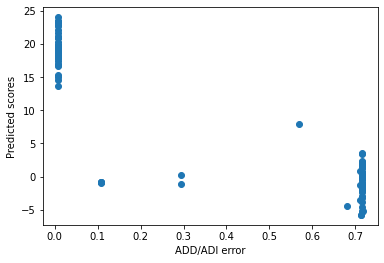

In [14]:
print("obj_id:", obj_id, "scene_id:", scene_id, "im_id:", im_id)
plt.scatter(err, pred_score)
plt.xlabel("ADD/ADI error")
plt.ylabel("Predicted scores")
plt.show()